Loaded 1080 prescription records

Analyzing medication A (medA)...


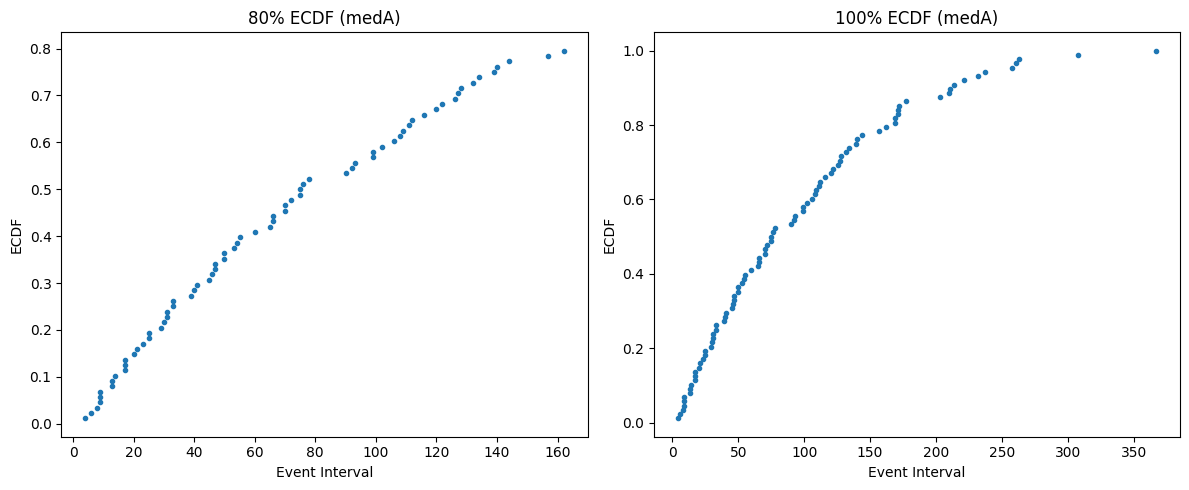

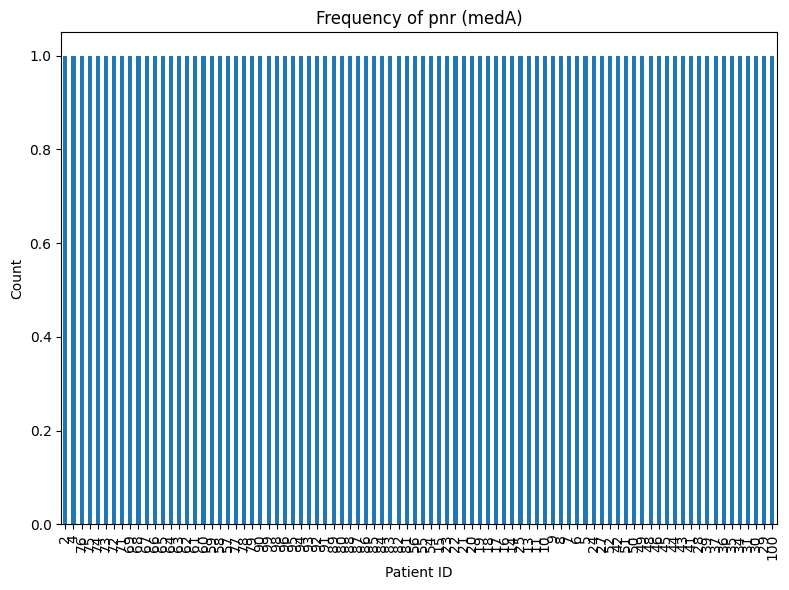

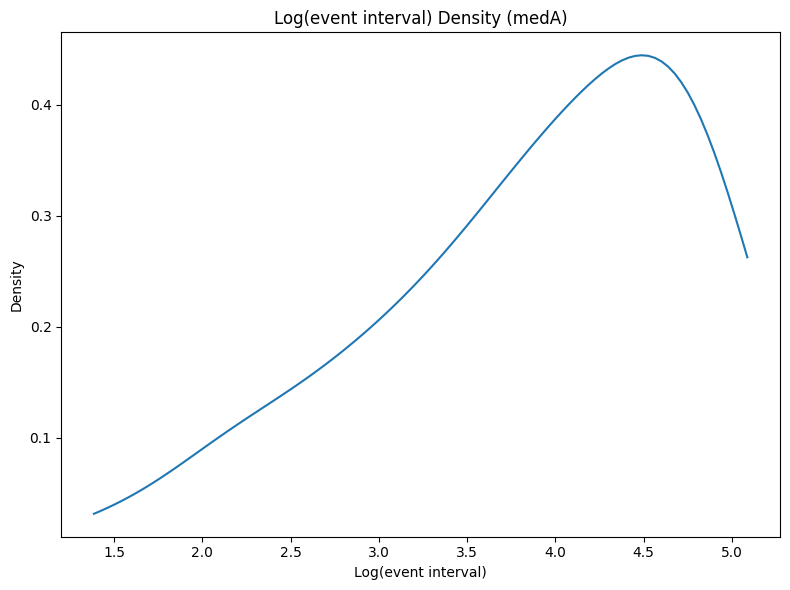

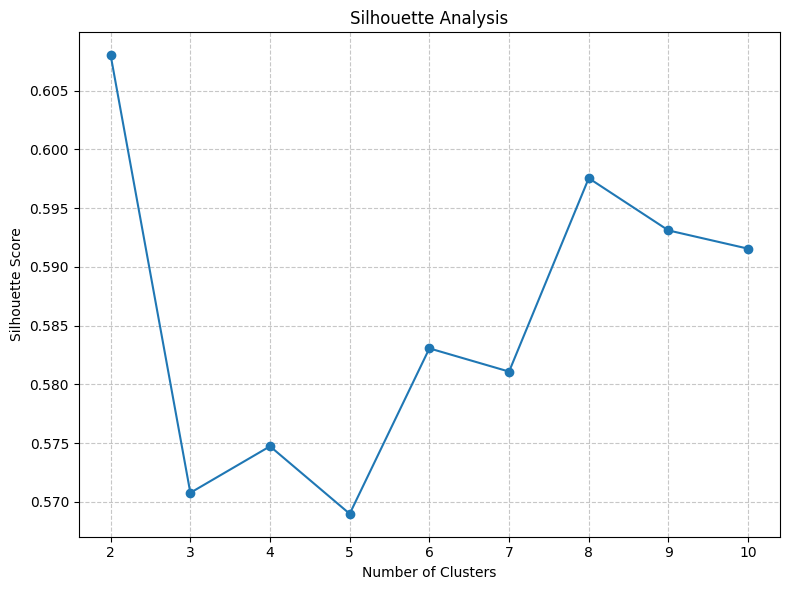


Analyzing medication B (medB)...


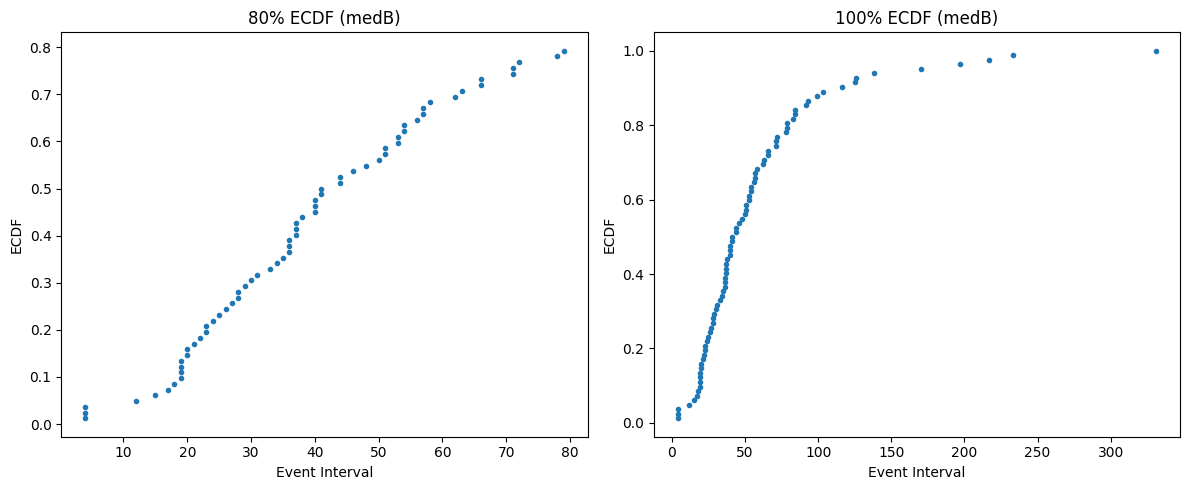

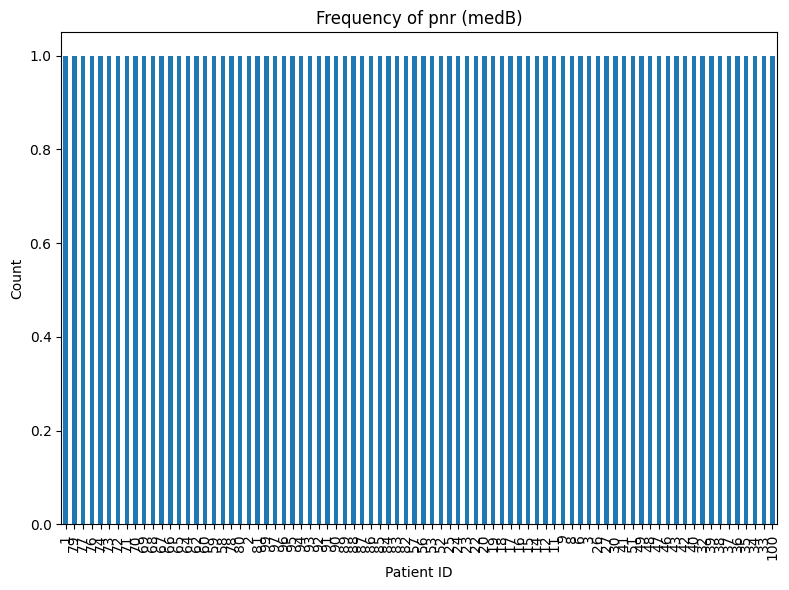

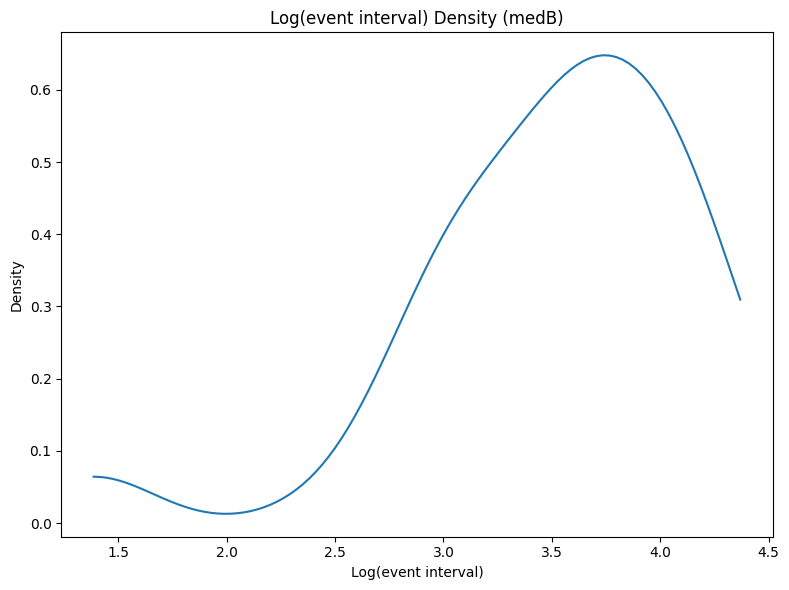

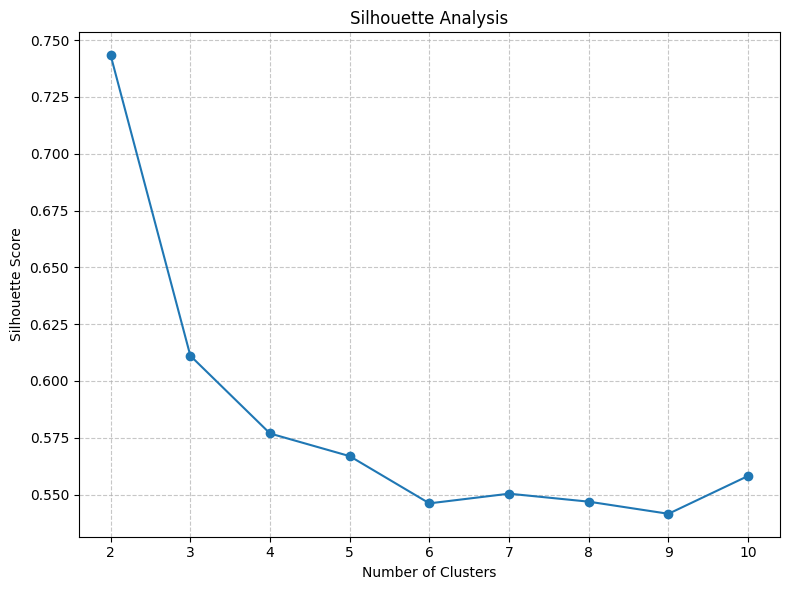


Creating prescription sequence boxplot for medA...


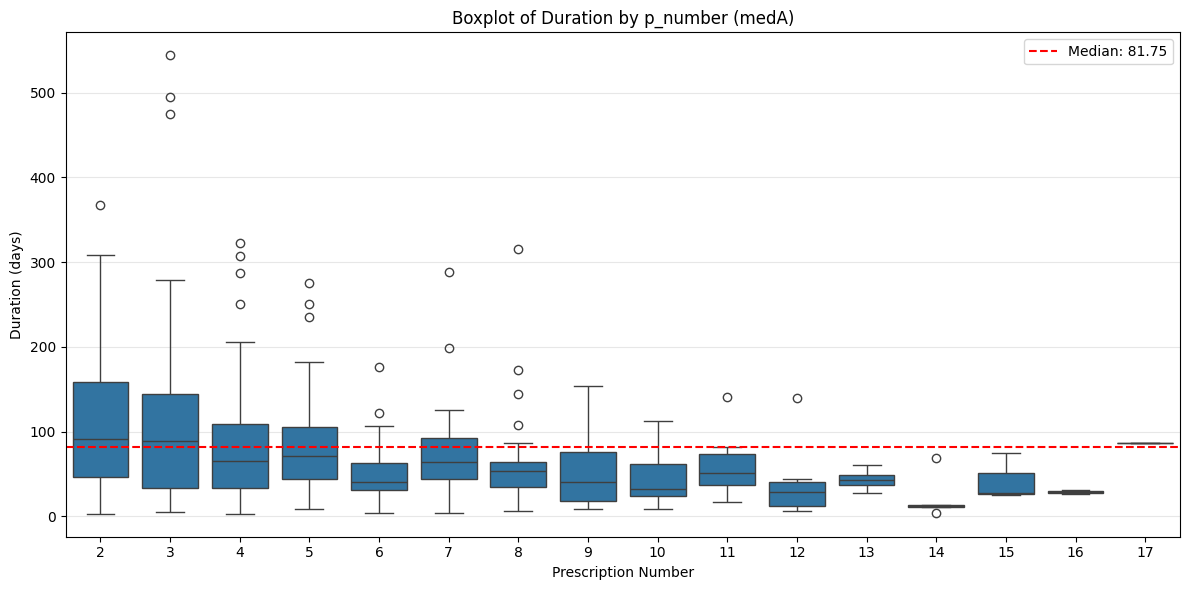


Creating prescription sequence boxplot for medB...


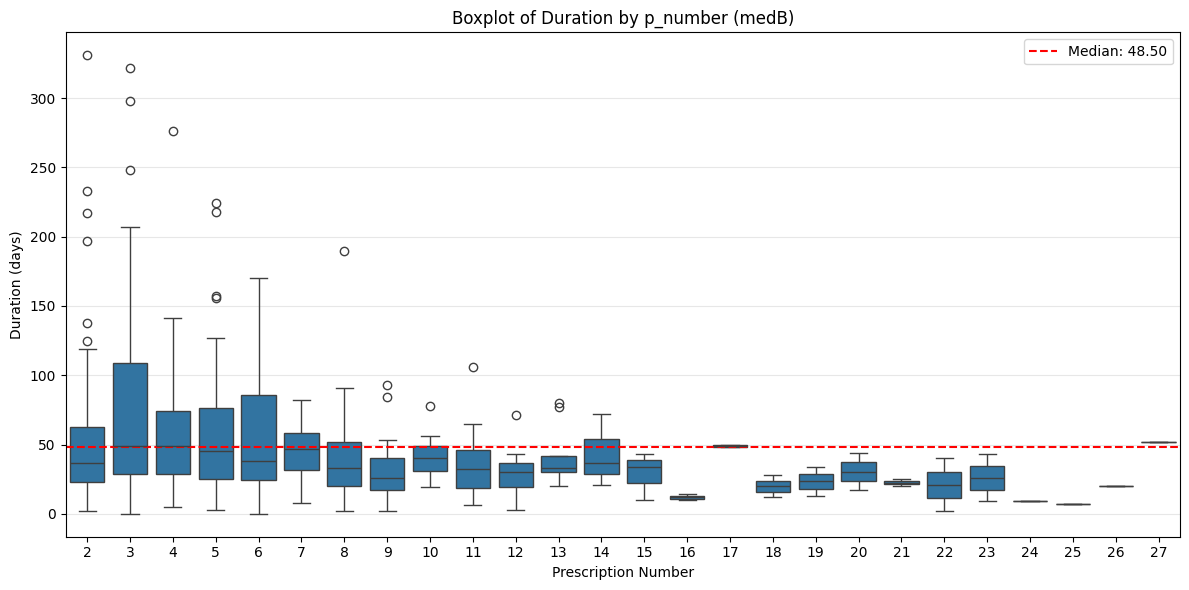


Analysis complete!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import gaussian_kde

# Set seed for reproducibility
np.random.seed(1234)

class MedicationAnalyzer:
    """Class for analyzing medication adherence patterns"""
    
    def __init__(self, data_path='med_events.csv'):
        """Initialize the analyzer with data path"""
        self.data_path = data_path
        self.medication_data = None
        self.load_data()
    
    def load_data(self):
        """Load and preprocess medication data"""
        # Read the data
        df = pd.read_csv(self.data_path)
        
        # Rename columns to match expected format
        self.medication_data = df.copy()
        self.medication_data.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
        
        # Convert date
        self.medication_data['eksd'] = pd.to_datetime(self.medication_data['eksd'])
        
        print(f"Loaded {len(self.medication_data)} prescription records")
    
    def analyze_medication(self, medication_code):
        """
        Analyze adherence patterns for a medication
        Similar to See() function in original code
        """
        # Filter for the specified medication
        med_subset = self.medication_data[self.medication_data['ATC'] == medication_code].copy()
        
        # Store original dataset
        drug_p0 = med_subset.copy()
        drug_p1 = med_subset.copy()
        
        # Calculate previous prescription date
        drug_p1 = drug_p1.sort_values(by=['pnr', 'eksd'])
        drug_p1['prev_eksd'] = drug_p1.groupby('pnr')['eksd'].shift(1)
        
        # Remove rows with no previous date
        drug_p1 = drug_p1.dropna(subset=['prev_eksd']).copy()
        
        # Sample 1 row per patient
        sampled_rows = []
        for name, group in drug_p1.groupby('pnr'):
            sampled_rows.append(group.sample(1, random_state=1234))
        drug_p1 = pd.concat(sampled_rows).reset_index(drop=True)
        
        # Keep needed columns and calculate interval
        drug_p1 = drug_p1[['pnr', 'eksd', 'prev_eksd']].copy()
        drug_p1['event_interval'] = (drug_p1['eksd'] - drug_p1['prev_eksd']).dt.days
        
        # Generate ECDF data
        valid_intervals = drug_p1[drug_p1['event_interval'] > 0]['event_interval']
        sorted_vals = np.sort(valid_intervals)
        ecdf_y = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        dfper = pd.DataFrame({'x': sorted_vals, 'y': ecdf_y})
        
        # Get 80% ECDF
        dfper_80 = dfper[dfper['y'] <= 0.8].copy()
        ni = dfper_80['x'].max() if not dfper_80.empty else dfper['x'].max()
        
        # Plot ECDFs
        self._plot_ecdf(dfper_80, sorted_vals, ecdf_y, medication_code)
        
        # Plot patient counts
        self._plot_patient_counts(drug_p1, medication_code)
        
        # Filter interval data and calculate log values
        drug_p2 = drug_p1[drug_p1['event_interval'] <= ni].copy()
        drug_p2 = drug_p2[drug_p2['event_interval'] > 0].copy()
        
        # Density estimation of log intervals
        log_vals = np.log(drug_p2['event_interval'])
        self._plot_log_density(log_vals, medication_code)
        
        # Calculate optimal number of clusters
        X_cluster = dfper['x'].values.reshape(-1, 1)
        max_cluster = self._find_optimal_clusters(X_cluster)
        
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=max_cluster, random_state=1234)
        dfper['cluster'] = kmeans.fit_predict(X_cluster)
        
        # Calculate cluster statistics
        dfper['log_x'] = np.log(dfper['x'])
        cluster_stats = dfper.groupby('cluster')['log_x'].agg(['min', 'max', 'median']).reset_index()
        
        # Convert back from log scale
        cluster_stats['Minimum'] = np.exp(cluster_stats['min'])
        cluster_stats['Maximum'] = np.exp(cluster_stats['max'])
        cluster_stats['Median'] = np.exp(cluster_stats['median'])
        cluster_stats = cluster_stats[cluster_stats['Median'] > 0].copy()
        
        # Create cross-join with intervals
        drug_p1['tmp_key'] = 1
        cluster_stats['tmp_key'] = 1
        results = pd.merge(drug_p1, cluster_stats, on='tmp_key').drop('tmp_key', axis=1)
        
        # Define which cluster each interval belongs to
        results['Final_cluster'] = np.where(
            (results['event_interval'] >= results['Minimum']) & 
            (results['event_interval'] <= results['Maximum']),
            results['cluster'], 
            np.nan
        )
        
        # Filter out rows without a cluster assignment
        results = results.dropna(subset=['Final_cluster']).copy()
        results = results[['pnr', 'Median', 'cluster']].rename(columns={'cluster': 'Cluster'})
        
        # Find most frequent cluster
        if not results.empty:
            cluster_freq = results['Cluster'].value_counts()
            most_freq_cluster = cluster_freq.idxmax()
            median_val = cluster_stats[cluster_stats['cluster'] == most_freq_cluster]['Median'].iloc[0]
        else:
            median_val = np.nan
        
        # Merge results back to drug_p1
        drug_p1 = pd.merge(drug_p1, results, on='pnr', how='left')
        drug_p1['Median'] = drug_p1['Median'].fillna(median_val)
        drug_p1['Cluster'] = drug_p1['Cluster'].fillna(0)
        
        # Calculate difference between interval and median
        drug_p1['test'] = np.round(drug_p1['event_interval'] - drug_p1['Median'], 1)
        
        # Create final result by merging back to original data
        drug_p3 = drug_p1[['pnr', 'Median', 'Cluster']].copy()
        drug_p0 = pd.merge(drug_p0, drug_p3, on='pnr', how='left')
        drug_p0['Median'] = drug_p0['Median'].fillna(median_val)
        drug_p0['Cluster'] = drug_p0['Cluster'].fillna(0)
        
        return drug_p0
    
    def _plot_ecdf(self, dfper_80, sorted_vals, ecdf_y, medication_code):
        """Plot empirical cumulative distribution functions"""
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        # 80% ECDF
        axs[0].plot(dfper_80['x'], dfper_80['y'], marker='.', linestyle='none')
        axs[0].set_title(f"80% ECDF ({medication_code})")
        axs[0].set_xlabel("Event Interval")
        axs[0].set_ylabel("ECDF")
        
        # 100% ECDF
        axs[1].plot(sorted_vals, ecdf_y, marker='.', linestyle='none')
        axs[1].set_title(f"100% ECDF ({medication_code})")
        axs[1].set_xlabel("Event Interval")
        axs[1].set_ylabel("ECDF")
        
        plt.tight_layout()
        plt.savefig(f"{medication_code}_ecdf.png")
        plt.show()
    
    def _plot_patient_counts(self, drug_p1, medication_code):
        """Plot frequency counts of patients"""
        counts = drug_p1['pnr'].value_counts()
        plt.figure(figsize=(8, 6))
        counts.plot(kind='bar')
        plt.title(f"Frequency of pnr ({medication_code})")
        plt.xlabel("Patient ID")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(f"{medication_code}_patient_counts.png")
        plt.show()
    
    def _plot_log_density(self, log_vals, medication_code):
        """Plot density of log intervals"""
        density = gaussian_kde(log_vals)
        x = np.linspace(log_vals.min(), log_vals.max(), 100)
        y = density(x)
        
        plt.figure(figsize=(8, 6))
        plt.plot(x, y)
        plt.title(f"Log(event interval) Density ({medication_code})")
        plt.xlabel("Log(event interval)")
        plt.ylabel("Density")
        plt.tight_layout()
        plt.savefig(f"{medication_code}_log_density.png")
        plt.show()
    
    def _find_optimal_clusters(self, data, max_clusters=10):
        """Find optimal number of clusters using silhouette score"""
        silhouette_scores = {}
        
        # Try various cluster counts
        for k in range(2, min(max_clusters, len(data) - 1) + 1):
            kmeans = KMeans(n_clusters=k, random_state=1234)
            labels = kmeans.fit_predict(data)
            
            try:
                score = silhouette_score(data, labels)
                silhouette_scores[k] = score
            except:
                continue
        
        # Plot silhouette scores
        plt.figure(figsize=(8, 6))
        plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
        plt.title("Silhouette Analysis")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Silhouette Score")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig("silhouette_scores.png")
        plt.show()
        
        # Return optimal number of clusters
        return max(silhouette_scores, key=silhouette_scores.get) if silhouette_scores else 2
    
    def analyze_prescription_sequence(self, medication_data, medication_code):
        """
        Create boxplot of duration by prescription number
        Equivalent to see_assumption function
        """
        # Sort data and calculate previous prescription date
        df_sorted = medication_data.sort_values(by=['pnr', 'eksd']).copy()
        df_sorted['prev_eksd'] = df_sorted.groupby('pnr')['eksd'].shift(1)
        
        # Create prescription sequence number
        df_sorted['p_number'] = df_sorted.groupby('pnr').cumcount() + 1
        
        # Filter for prescriptions with previous date (p_number >= 2)
        subset = df_sorted[df_sorted['p_number'] >= 2].copy()
        subset = subset[['pnr', 'eksd', 'prev_eksd', 'p_number']].copy()
        
        # Calculate duration between prescriptions
        subset['Duration'] = (subset['eksd'] - subset['prev_eksd']).dt.days
        
        # Convert p_number to string for plotting
        subset['p_number'] = subset['p_number'].astype(str)
        
        # Calculate patient-level medians and overall median
        patient_medians = subset.groupby('pnr')['Duration'].median()
        overall_median = patient_medians.median()
        
        # Create boxplot
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(x='p_number', y='Duration', data=subset)
        
        # Add reference line for overall median
        plt.axhline(y=overall_median, color='red', linestyle='--', 
                   label=f"Median: {overall_median:.2f}")
        
        plt.title(f"Boxplot of Duration by p_number ({medication_code})")
        plt.xlabel("Prescription Number")
        plt.ylabel("Duration (days)")
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{medication_code}_boxplot.png")
        plt.show()
        
        return subset

def main():
    """Main function to run the analysis"""
    # Create analyzer
    analyzer = MedicationAnalyzer()
    
    # Analyze medications
    print("\nAnalyzing medication A (medA)...")
    medA_results = analyzer.analyze_medication("medA")
    
    print("\nAnalyzing medication B (medB)...")
    medB_results = analyzer.analyze_medication("medB")
    
    # Create prescription sequence boxplots
    print("\nCreating prescription sequence boxplot for medA...")
    analyzer.analyze_prescription_sequence(medA_results, "medA")
    
    print("\nCreating prescription sequence boxplot for medB...")
    analyzer.analyze_prescription_sequence(medB_results, "medB")
    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()